In [8]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [37]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
import random
import shap


## Загружаем датасет и проверяем

In [3]:

mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 11s 1us/step


In [4]:
print(f"Train images shape: {train_images.shape}")  
print(f"Train labels shape: {train_labels.shape}")  
print(f"Test images shape: {test_images.shape}")    
print(f"Test labels shape: {test_labels.shape}")   

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [9]:
# Нормализуем данные и переводим их в вектора
train_images = train_images.reshape(train_images.shape[0], 28 * 28) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28 * 28) / 255.0


In [11]:
# Создаем модель
model = keras.Sequential([
    keras.layers.Input(shape=(784,)),  # 784 признака (развернутое изображение)
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')  # 10 классов (цифры 0-9)
])

# Компилируем модель
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Обучаем модель
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Оценим точность модели
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nТестовая точность:', test_acc)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5623 - loss: 1.3747 - val_accuracy: 0.8691 - val_loss: 0.4537
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8776 - loss: 0.4257 - val_accuracy: 0.8997 - val_loss: 0.3474
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9011 - loss: 0.3407 - val_accuracy: 0.9098 - val_loss: 0.3113
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9122 - loss: 0.3047 - val_accuracy: 0.9216 - val_loss: 0.2771
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9179 - loss: 0.2814 - val_accuracy: 0.9255 - val_loss: 0.2549
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9276 - loss: 0.2443 - val_accuracy: 0.9323 - val_loss: 0.2308
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9329 - loss: 0.2293 - val_accuracy: 0.9366 - val_loss: 0.2117
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9402 - loss: 0.2014 - 

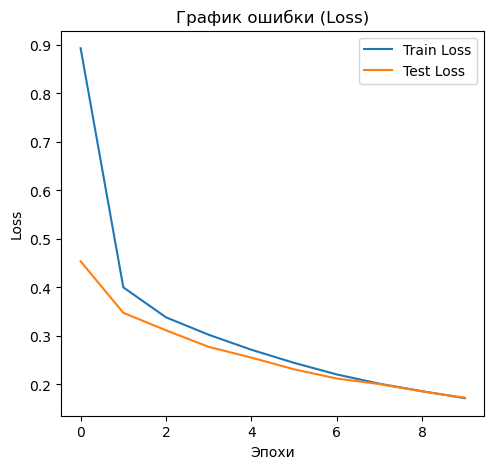

In [12]:
# График ошибки (Loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('График ошибки (Loss)')
plt.legend()


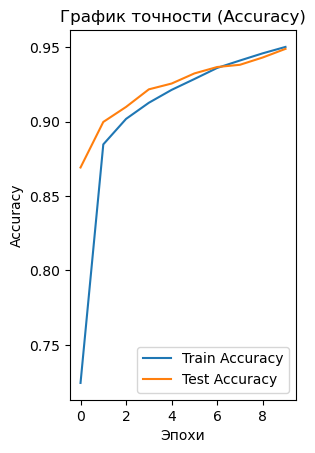

In [13]:
# График точности (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.title('График точности (Accuracy)')
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


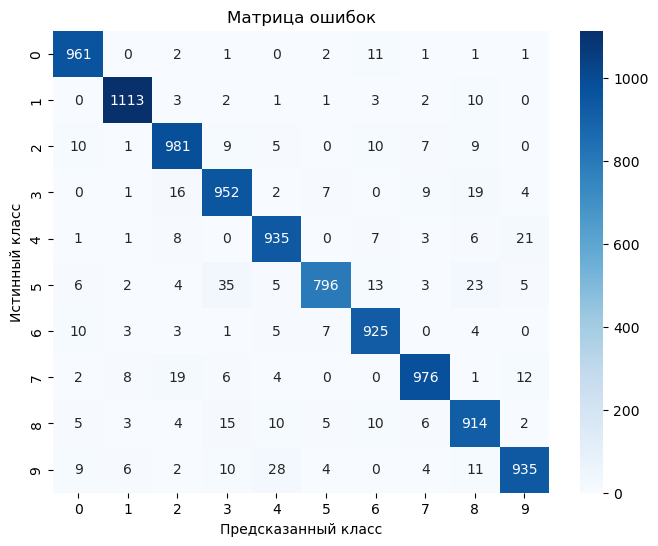

In [15]:
# Делаем предсказания на тестовой выборке
y_pred = np.argmax(model.predict(test_images), axis=1)

# Создаём матрицу ошибок
cm = confusion_matrix(test_labels, y_pred)

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

### Нужные данные расположены на диагонали и там мы имее очнеь орощие результаты, цифры вне диагонали в 10-20 раз меньше

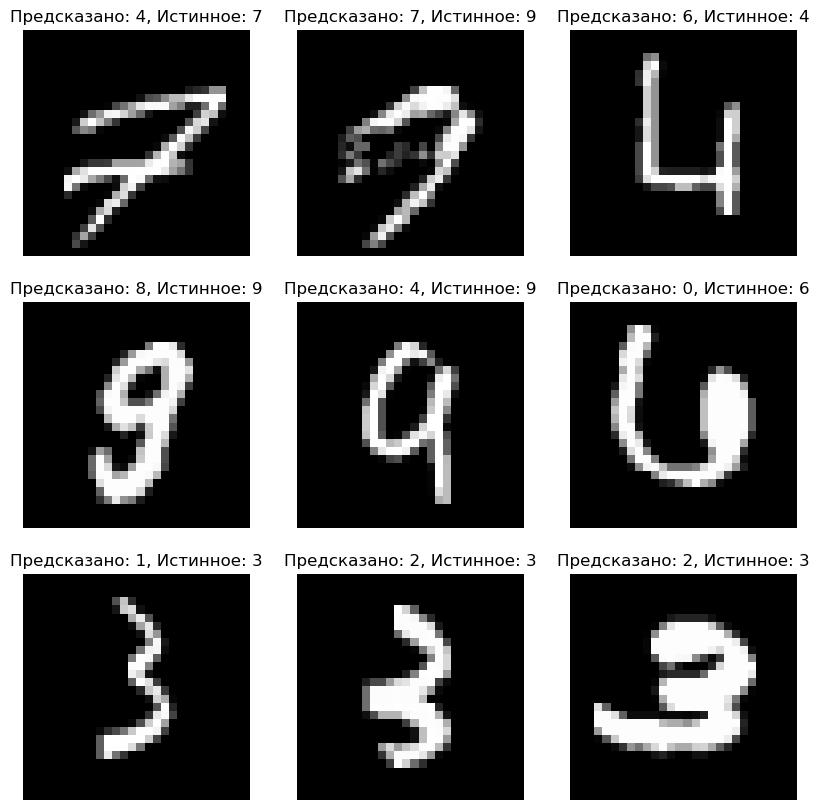

In [17]:
# Выбираем индексы неправильных предсказаний
incorrect = np.where(y_pred != test_labels)[0]

# Выбираем случайные 9 ошибок
random_incorrect = np.random.choice(incorrect, 9, replace=False)

# Рисуем изображения с предсказаниями
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_incorrect):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Предсказано: {y_pred[idx]}, Истинное: {test_labels[idx]}")
    plt.axis("off")

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


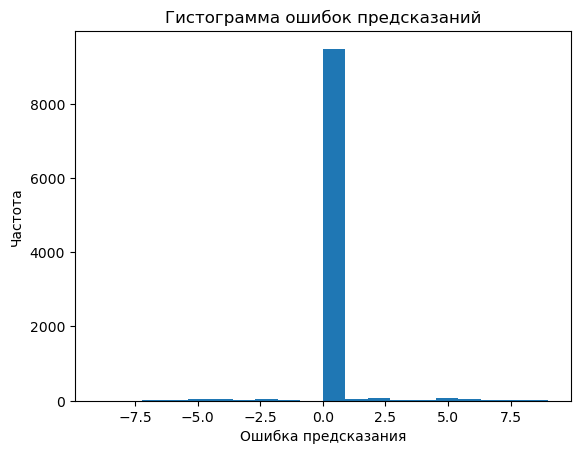

In [22]:
# Получаем предсказания
y_pred = np.argmax(model.predict(test_images), axis=1)

# Вычисляем ошибки предсказания
errors = test_labels - y_pred

# Строим гистограмму ошибок
plt.hist(errors, bins=20)
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Гистограмма ошибок предсказаний')
plt.show()

In [ ]:
r2 = r2_score(y_train_filtered_clean, model_quantile_clean.predict(X_train_scaled_filtered_clean))
print(f"R²-score: {r2:.4f}")

In [ ]:
residuals = y_train_filtered_clean - model_quantile_clean.predict(X_train_scaled_filtered_clean)
stat, p = shapiro(residuals)
print(f"p-value: {p:.4f}")

if p > 0.05:
    print("Распределение остатков похоже на нормальное (p > 0.05)")
else:
    print("Остатки не нормальны (p < 0.05), возможно, модель делает систематические ошибки")

## Вывод график почти симметричный

In [30]:
# Создаем модель
def create_model():
    model = tf.keras.Sequential([
        keras.layers.Input(shape=(784,)),
        keras.layers.Dense(256),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(alpha=0.1),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Список для хранения историй
histories = []

# Компилируем модель
optimizers = [
    tf.keras.optimizers.Adam(learning_rate=0.001),
    tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    tf.keras.optimizers.RMSprop(learning_rate=0.001)
]

for optimizer in optimizers:
    model = create_model()  # Создаем новую модель для каждого оптимизатора
    print(f"Testing with optimizer: {optimizer}")
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint(f"model_{optimizer}.keras", monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), callbacks=callbacks)
    histories.append(history)
    
    # Выведем результаты обучения для каждого оптимизатора
    print(f"Finished training with {optimizer}.")
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
    print(f"Test accuracy: {test_acc}")

Testing with optimizer: <keras.src.optimizers.adam.Adam object at 0x778edeebe960>
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8490 - loss: 0.5201 - val_accuracy: 0.8728 - val_loss: 0.3917 - learning_rate: 0.0010
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9433 - loss: 0.1857 - val_accuracy: 0.9125 - val_loss: 0.2630 - learning_rate: 0.0010
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9545 - loss: 0.1507 - val_accuracy: 0.9321 - val_loss: 0.2171 - learning_rate: 0.0010
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9617 - loss: 0.1254 - val_accuracy: 0.9582 - val_loss: 0.1255 - learning_rate: 0.0010
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9659 - loss: 0.1132 - val_accuracy: 0.9538 - val_loss: 0.1482 - learning_rate: 0.0010
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9699 - loss: 0.0989 - val_accuracy: 0.9662 - val_loss: 0.1056 - learning_rate: 0

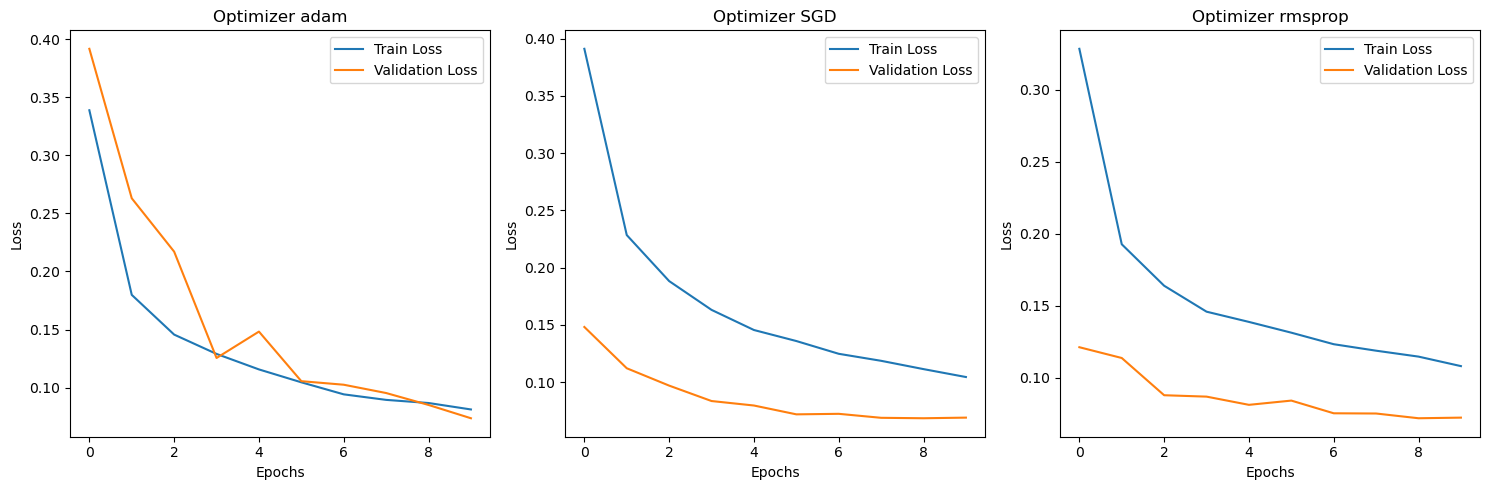

In [31]:
# Создаем графики для сравнения
plt.figure(figsize=(15, 5))

# Для каждого оптимизатора
for i, history in enumerate(histories):
    plt.subplot(1, 3, i + 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Optimizer {optimizers[i].get_config()['name']}")
    plt.legend()

plt.tight_layout()
plt.show()

### Данные билзкиепо цифрам RMSprop показал наибюолее лучшие результаты как по точности так и по Loss

# Попробуем сделать кроссвалидацию 

In [32]:
# Загрузка моделей
model_adam = keras.models.load_model("model_adam.keras")
model_sgd = keras.models.load_model("model_sgd.keras")
model_rmsprop = keras.models.load_model("model_rmsprop.keras")

## Попробуем Ансамблирование

In [33]:
# Предсказания от каждой модели
y_pred_adam = model_adam.predict(test_images)
y_pred_sgd = model_sgd.predict(test_images)
y_pred_rmsprop = model_rmsprop.predict(test_images)

# Усреднение предсказаний для ансамблирования (для классификации)
y_pred_ensemble = (y_pred_adam + y_pred_sgd + y_pred_rmsprop) / 3

# Для классификации: выбираем класс с наибольшим значением
final_predictions = np.argmax(y_pred_ensemble, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Ensemble Model Accuracy: 98.26%


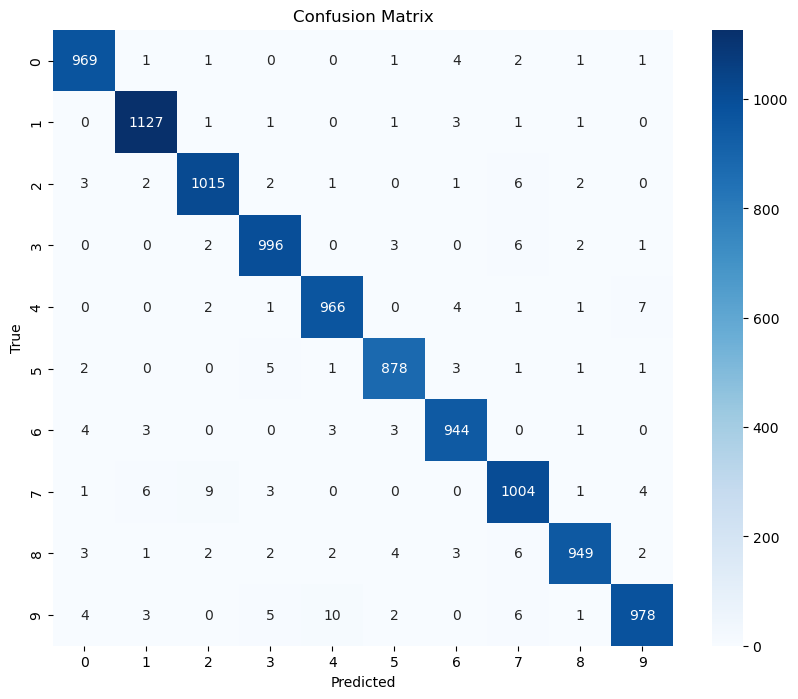

Ensemble Model F1 Score: 0.98


In [36]:
# Рассчитываем точность ансамблированной модели
accuracy = accuracy_score(test_labels, final_predictions)
print(f"Ensemble Model Accuracy: {accuracy * 100:.2f}%")

# Матрица ошибок
cm = confusion_matrix(test_labels, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# F1 score
f1 = f1_score(test_labels, final_predictions, average='weighted')
print(f"Ensemble Model F1 Score: {f1:.2f}")

### Вывод: Ассамблированная модель получилась точнее чем отдельные модели и матрица ошибок значителбно лучше.

## Попробуем Стэкинг

In [41]:
# Создаем метамодель (логистическую регрессию)

# Предсказания от каждой модели
y_pred_adam = model_adam.predict(test_images)
y_pred_sgd = model_sgd.predict(test_images)
y_pred_rmsprop = model_rmsprop.predict(test_images)

# Конкатенируем предсказания как новые признаки
X_meta = np.concatenate([y_pred_adam, y_pred_sgd, y_pred_rmsprop], axis=1)

# Разделим на обучающую и тестовую выборки для метамодели
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, test_labels, test_size=0.3)

# Обучаем метамодель
meta_model = LogisticRegression()
meta_model.fit(X_train_meta, y_train_meta)

# Предсказания метамодели
final_predictions_meta = meta_model.predict(X_test_meta)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Ensemble Model Accuracy: 98.17%


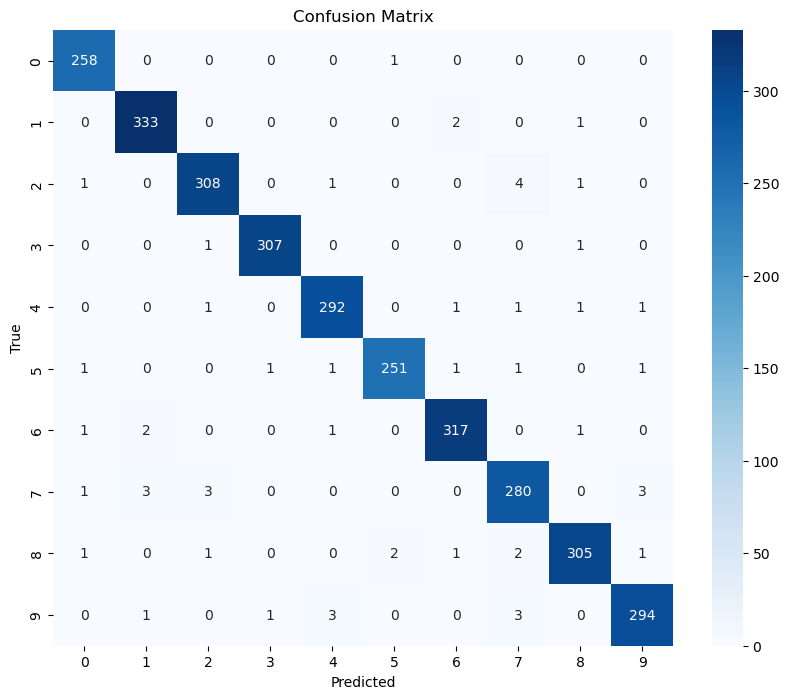

Ensemble Model F1 Score: 0.98


In [42]:
# Рассчитываем точность ансамблированной модели
accuracy = accuracy_score(y_test_meta, final_predictions_meta)
print(f"Ensemble Model Accuracy: {accuracy * 100:.2f}%")

# Матрица ошибок
cm = confusion_matrix(y_test_meta, final_predictions_meta)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# F1 score
f1 = f1_score(y_test_meta, final_predictions_meta, average='weighted')
print(f"Ensemble Model F1 Score: {f1:.2f}")

### Вывод: Стэкинг модель получилась по точности аналогично асамблированной что показввает, что кроссвалидация улучшила нашу модель